In [1]:
import numpy as np
import multiprocessing as mp
from xclib.data import data_utils
import scipy
import math  
from tqdm import tqdm
from time import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pickle
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
%notebook inline

ModuleNotFoundError: ignored

In [2]:
mp.cpu_count()

40

In [0]:
# !pip install git+https://github.com/kunaldahiya/xclib.git

In [0]:
path = "/content/drive/My Drive/ML/virus/ass3_parta_data"
trainX = data_utils.read_sparse_file(path+"/train_x.txt").toarray()
trainY = np.loadtxt(path+"/train_y.txt")
testX = data_utils.read_sparse_file(path+"/test_x.txt").toarray()
testY = np.loadtxt(path+"/test_y.txt")
valX = data_utils.read_sparse_file(path+"/valid_x.txt").toarray()
valY = np.loadtxt(path+"/valid_y.txt")

/usr/local/lib/python3.6/dist-packages/xclib/data/data_utils.py:173: UserWarning: Header mis-match from inferred shape!
  warnings.warn("Header mis-match from inferred shape!")


In [0]:
class Node:
    def __init__(self,attr,splitVal,value,left,right):
        self.left = left
        self.right = right
        self.attr = attr
        self.splitVal = splitVal
        self.majority = value
        
class DecisionTree:
    def __init__(self):
        return

    def traverseTree(self,x,node):
        if(node.left==None and node.right==None):
            return node.majority
        if(x[node.attr]<=node.splitVal):
            return self.traverseTree(x,node.left)
        return self.traverseTree(x,node.right)

    def predict(self,dataX):
        predictions = []
        for i in dataX:
            predictions.append(self.traverseTree(i,self.root))
        predictions = np.array(predictions)
        return predictions

    def chooseBestAttr(self,dataX,dataY):
        pos = np.sum(dataY==1)
        neg = dataY.shape[0]-pos
        HY = -(pos/dataY.shape[0])*math.log(pos/dataY.shape[0])-(neg/dataY.shape[0])*math.log(neg/dataY.shape[0])
        entropyList=[]
        for i in (range(dataX.shape[1])):
            seq = dataX[:,i]
            splitVal = np.median(seq)
            indices0 = np.where(dataX[:,i] <= splitVal)[0]
            indices1 = np.where(dataX[:,i] > splitVal)[0]
            if(indices0.shape[0]==0 or indices1.shape[0]==0):
                entropyList.append(0)
                continue

            D0,Y0 = dataX[indices0,:],dataY[indices0]
            D1,Y1 = dataX[indices1,:],dataY[indices1]

            pos = np.sum(Y0==1)
            neg = Y0.shape[0]-pos
            if(pos==0 or neg==0):
                H0=0
            else:
                H0 = -(pos/Y0.shape[0])*math.log(pos/Y0.shape[0])-(neg/Y0.shape[0])*math.log(neg/Y0.shape[0])
            H0 = (indices0.shape[0]/dataX.shape[0])*H0
            pos = np.sum(Y1==1)
            neg = Y1.shape[0]-pos
            if(pos==0 or neg==0):
                H1=0
            else:
                H1 = -(pos/Y1.shape[0])*math.log(pos/Y1.shape[0])-(neg/Y1.shape[0])*math.log(neg/Y1.shape[0])
            H1 = (indices1.shape[0]/dataX.shape[0])*H1
            entropyList.append(HY-H0-H1)
        if(sum(entropyList)==0):
            return -1
        return entropyList.index(max(entropyList))
    
    def growTree(self,dataX,dataY,testX,testY,valX,valY,interval):
        queue = [(self.root,dataX,dataY)]
        count = 0
        nodeCount,trainList,testList,valList = [],[],[],[]
        while(len(queue)!=0):
            x,DX,DY = queue.pop(0)
            s = np.sum(DY)
            if(s == DY.shape[0]):
                continue
            if(s == 0):
                continue

            attr = self.chooseBestAttr(DX,DY)

            if(s > DY.shape[0]/2):
                val=1
            else:
                val=0

            if(attr == -1):
                continue            

            seq = DX[:,attr]
            splitVal = np.median(seq)
            indices0 = np.where(DX[:,attr] <= splitVal)[0]
            indices1 = np.where(DX[:,attr] > splitVal)[0]
            D0,Y0 = DX[indices0,:],DY[indices0]
            D1,Y1 = DX[indices1,:],DY[indices1]

            x.attr,x.splitVal,x.majority = attr,splitVal,val

            s = np.sum(Y0)
            if(s > Y0.shape[0]/2):
                v = 1
            else:
                v = 0
            left = Node(-1,-1,v,None,None)

            s = np.sum(Y1)
            if(s > Y1.shape[0]/2):
                v = 1
            else:
                v = 0
            right = Node(-1,-1,v,None,None)

            x.left,x.right = left,right
            queue.append((left,D0,Y0))
            queue.append((right,D1,Y1))
            count+=1

            if(count%interval==0):
                nodeCount.append(self.findNodes(self.root))
                trainList.append(self.score(self.predict(dataX),dataY))
                testList.append(self.score(self.predict(testX),testY))
                valList.append(self.score(self.predict(valX),valY))
        return nodeCount,trainList,testList,valList
        # attr = self.chooseBestAttr(dataX,dataY)
        # s = np.sum(dataY)
        # if(s > dataY.shape[0]/2):
        #     val=1
        # else:
        #     val=0
        # if(attr==-1):
        #     return Node(-1,-1,val,None,None)

        # seq = dataX[:,attr]
        # splitVal = np.median(seq)
        # indices0 = np.where(dataX[:,attr] <= splitVal)[0]
        # indices1 = np.where(dataX[:,attr] > splitVal)[0]
        # D0,Y0 = dataX[indices0,:],dataY[indices0]
        # D1,Y1 = dataX[indices1,:],dataY[indices1]

        # return Node(attr,splitVal,val,self.growTree(D0,Y0),self.growTree(D1,Y1))

    def fit(self,trainX,trainY,testX,testY,valX,valY,interval):
        s = np.sum(trainY)
        if(s > trainY.shape[0]/2):
            v = 1
        else:
            v = 0
        self.root = Node(-1,-1,v,None,None)
        nodeCount,trainList,testList,valList = self.growTree(trainX,trainY,testX,testY,valX,valY,interval)
        return nodeCount,trainList,testList,valList

    def findDepth(self,root):
        if(root==None):
            return 0
        return max(self.findDepth(root.left),self.findDepth(root.right))+1
    
    def findNodes(self,root):
        if(root==None):
            return 0
        l = self.findNodes(root.left)
        r = self.findNodes(root.right)
        return l+r+1
    
    def score(self,pred,dataY):
        check = (pred==dataY)
        return np.sum(check)/dataY.shape[0]

    def checkBinary(self,root):
        if(root.left==None and root.right==None):
            return 1
        if(root.left!=None):
            l = self.checkBinary(root.left)
        else:
            l=0
        if(root.right!=None):
            r = self.checkBinary(root.right)
        else:
            r=0
        return (l and r)

    def pruneNodes(self,root,trainX,trainY,testX,testY,valX,valY,acc):
        if(root.left==None and root.right==None):
            return acc
        acc1 = self.pruneNodes(root.left,trainX,trainY,testX,testY,valX,valY,acc)
        acc2 = self.pruneNodes(root.right,trainX,trainY,testX,testY,valX,valY,acc1)

        # if(root.left.left==None and root.left.right==None and root.right.left==None and root.right.right==None):
        tempAtt = root.attr
        tempLeft = root.left
        tempRight = root.right
        tempSplit = root.splitVal

        root.attr = -1
        root.splitVal = -1
        root.left = None
        root.right = None
        newAcc = self.score(self.predict(valX),valY)
        if(newAcc < acc2):
            root.attr = tempAtt
            root.left = tempLeft
            root.right = tempRight
            root.splitVal = tempSplit
            return acc2
        else:
            # accList.append((self.findNodes(self.root),self.score(self.predict(trainX),trainY),self.score(self.predict(testX),testY),self.score(self.predict(valX),valY)))
            return newAcc
                
        # return acc2

    def prune(self,trainX,trainY,testX,testY,valX,valY):
        acc = self.score(self.predict(valX),valY)
        self.pruneNodes(self.root,trainX,trainY,testX,testY,valX,valY,acc)
        # return accList

In [0]:
interval = 30
clf = DecisionTree()
try:
    st = time()
    pickle_in = open("/content/drive/My Drive/ML/treeGrowAcc.pickle","rb")
    clf,nodeCount,trainList,testList,valList = pickle.load(pickle_in)
    print(time()-st)
except:
    st = time()
    nodeCount,trainList,testList,valList = clf.fit(trainX,trainY,testX,testY,valX,valY,interval)
    print(time()-st)
    with open('/content/drive/My Drive/ML/treeGrowAcc.pickle', 'wb') as f:
        pickle.dump((clf,nodeCount,trainList,testList,valList), f)

0.9642136096954346


In [0]:
print(clf.findNodes(clf.root))
print(len(nodeCount),len(trainList),len(testList),len(valList))

20045
334 334 334 334


In [0]:
predTrain = clf.predict(trainX)
trainScore = clf.score(predTrain,trainY)
print(trainScore)
predTest = clf.predict(testX)
testScore = clf.score(predTest,testY)
print(testScore)
predVal = clf.predict(valX)
valScore = clf.score(predVal,valY)
print(valScore)

0.9047023009287161
0.7797505910713458
0.775913220841832


## PART B

In [0]:
clf.prune(trainX,trainY,testX,testY,valX,valY)

In [0]:
try:
    st = time()
    pickle_in = open("/content/drive/My Drive/ML/prunedTree.pickle","rb")
    clf,prunedList = pickle.load(pickle_in)
    print(time()-st)
except:
    st = time()
    prunedList = clf.prune(trainX,trainY,testX,testY,valX,valY)
    print(time()-st)
    with open('/content/drive/My Drive/ML/prunedTree.pickle', 'wb') as f:
        pickle.dump((clf,prunedList), f)

In [0]:
clf.findNodes(clf.root)

7407

In [0]:
predTrain = clf.predict(trainX)
trainScore = clf.score(predTrain,trainY)
print(trainScore)
predTest = clf.predict(testX)
testScore = clf.score(predTest,testY)
print(testScore)
predVal = clf.predict(valX)
valScore = clf.score(predVal,valY)
print(valScore)

0.8545732696676093
0.7921746789671318
0.8128592620063044


## PART C

In [0]:
def scorer(clf,X,y):
    return clf.oob_score_
rf = RandomForestClassifier(criterion='entropy',oob_score=True,n_jobs=-1)
parameters = {'n_estimators':[50,150,250,350,450],'max_features':[0.1,0.3,0.5,0.7,0.9,1],'min_samples_split':[2,4,6,8,10]}
gridSearchclf = GridSearchCV(rf, parameters,n_jobs=-1,scoring=scorer)

In [0]:
# 9342.362
try:
  st = time()
  pickle_in = open("/content/drive/My Drive/ML/grid.pickle","rb")
  gridSearchclf = pickle.load(pickle_in)
  print(time()-st)
except:
  st = time()
  gridSearchclf.fit(trainX,trainY)
  print(time()-st)
  with open("/content/drive/My Drive/ML/grid.pickle","wb") as f:
    pickle.dump(gridSearchclf, f)

1.6520686149597168


In [0]:
gridSearchclf.best_params_
best_max_features = gridSearchclf.best_params_['max_features']
best_min_samples_split = gridSearchclf.best_params_['min_samples_split']
best_n_estimators = gridSearchclf.best_params_['n_estimators']
rf = RandomForestClassifier(criterion='entropy',n_estimators=best_n_estimators,max_features=best_max_features,min_samples_split=best_min_samples_split,oob_score=True,n_jobs=-1)

In [0]:
st = time()
rf.fit(trainX,trainY)
print("Time",time()-st)
print(rf.score(trainX,trainY))
print(rf.oob_score_)
print(rf.score(testX,testY))
print(rf.score(valX,valY))

Time 103.24988174438477
0.8757436681964984
0.8089101107969032
0.8076120717630152
0.806925644353792


In [0]:
def findAcc(params,data):
    rf = RandomForestClassifier(criterion='entropy',n_estimators=params[0],min_samples_split=params[1],max_features=params[2],oob_score=True,n_jobs=-1)
    rf.fit(data[0],data[1])
    return (rf.score(data[2],data[3]),rf.score(data[4],data[5]))

In [0]:
def paramSensitivity(estimatorList,minSamplesList,maxFeaturesList):
    n_estimators_varied,min_samples_split_varied,max_features_varied = [],[],[]
    data = (trainX,trainY,testX,testY,valX,valY)
    for i in estimatorList:
        n_estimators_varied.append(findAcc((i,best_min_samples_split,best_max_features),data))
    print("estimators",e_estimators_varied)

    for i in minSamplesList:
        min_samples_split_varied.append(findAcc((best_n_estimators,i,best_max_features),data))
    print("min samples split",min_samples_split_varied)

    for i in maxFeaturesList:
        max_features_varied.append(findAcc((best_n_estimators,best_min_samples_split,i),data))
    print("max features",max_features_varied)

    return n_estimators_varied,min_samples_split_varied,max_features_varied

In [0]:
estimatorList = [50,150,250,350,450]
minSamplesList = [2,4,6,8,10]
maxFeaturesList = [0.1,0.3,0.5,0.7,0.9,1]

try:
    st = time()
    pickle_in = open("/content/drive/My Drive/ML/paramSensitivity.pickle","rb")
    n_estimators_varied,min_samples_split_varied,max_features_varied = pickle.load(pickle_in)
    print(time()-st)
except:
    st = time()
    n_estimators_varied,min_samples_split_varied,max_features_varied = paramSensitivity(estimatorList,minSamplesList,maxFeaturesList)  
    print(time()-st)
    with open("/content/drive/My Drive/ML/paramSensitivity.pickle","wb") as f:
        pickle.dump((e_estimators_varied,min_samples_split_varied,max_features_varied), f)

0.005791425704956055


In [0]:
def plotForest(x,y,title,leg):
    y = np.array(y)
    plt.figure(figsize=(8,6))
    ax = plt.gca()
    ax.plot(x,y[:,0],label="Test Set Accuracies")
    ax.plot(x,y[:,1],label="Validation Set Accuracies")
    plt.title(title)
    ax.set_xlabel("n_estimator",fontsize=12)
    ax.set_ylabel("Accuracies",fontsize=12)
    plt.legend(loc=leg)
    plt.show()

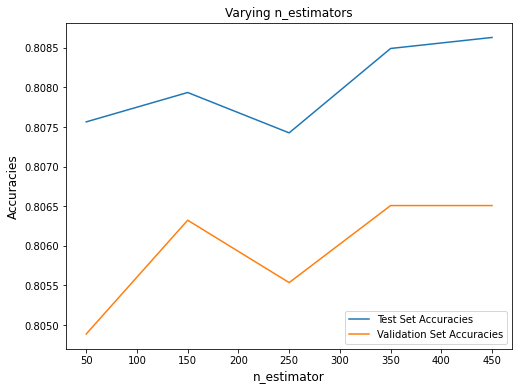

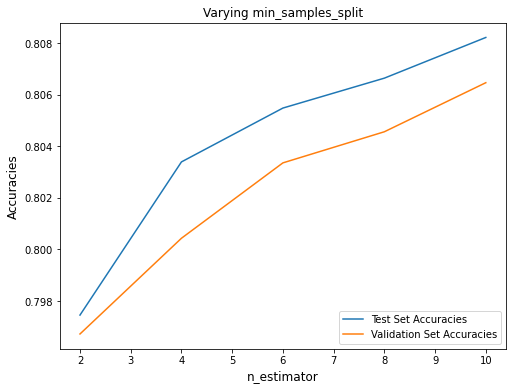

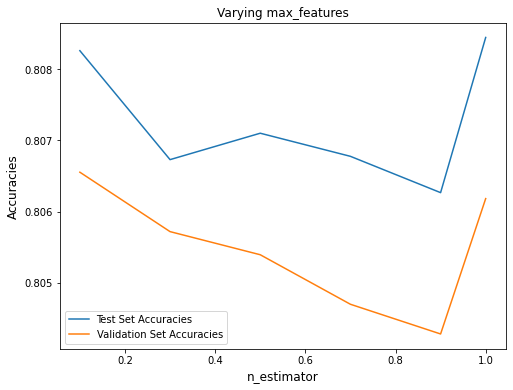

In [0]:
plotForest(estimatorList,n_estimators_varied,"Varying n_estimators","lower right")
plotForest(minSamplesList,min_samples_split_varied,"Varying min_samples_split","lower right")
plotForest(maxFeaturesList,max_features_varied,"Varying max_features","lower left")